In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

In [1]:
%matplotlib inline
import gc
from typing import Union
import os

import cugraph as cg
import cudf
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

pd.set_option('display.max_columns', 500)
sns.set()

In [2]:
!nvidia-smi

Tue Aug  3 05:33:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    41W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [3]:
# this is the cleaned up data.
datafp = './data/credit_card/card_transaction_fixed.pq'
gdf = cudf.read_parquet(datafp)
# if not use_raw:
gdf['zip'] = gdf.zip.astype(int).astype(str)
gdf['use chip'] = gdf['use chip'].str.strip()
gdf['merchant city'] = gdf['merchant city'].str.strip()

In [4]:
len(gdf)

24386900

# Prep 

In [5]:
gdf.head()

,user,card,date,year,month,day,time,hour,minute,amount,use chip,merchant name,merchant city,merchant state,zip,mcc,errors,is_fraud
0,791,1,1991-01-02 07:10:00,1991,1,2,07:10,7,10,68.00,Swipe Transaction,2027553650310142703,Burke,VA,22015,5541,<NA>,0
1,791,1,1991-01-02 07:17:00,1991,1,2,07:17,7,17,-68.00,Swipe Transaction,2027553650310142703,Burke,VA,22015,5541,<NA>,0
2,791,1,1991-01-02 07:21:00,1991,1,2,07:21,7,21,113.62,Swipe Transaction,2027553650310142703,Burke,VA,22015,5541,<NA>,0
3,791,1,1991-01-02 17:30:00,1991,1,2,17:30,17,30,114.73,Swipe Transaction,-7269691894846892021,Burke,VA,22015,5411,<NA>,0
4,791,1,1991-01-03 09:03:00,1991,1,3,09:03,9,3,251.71,Swipe Transaction,-3693650930986299431,Burke,VA,22015,4814,<NA>,0


In [6]:
gdf.errors.value_counts()

Insufficient Balance,                                   242783
Bad PIN,                                                 58918
Technical Glitch,                                        48157
Bad Card Number,                                         13321
Bad CVV,                                                 10740
Bad Expiration,                                          10716
Bad Zipcode,                                              2079
Bad PIN,Insufficient Balance,                              581
Insufficient Balance,Technical Glitch,                     457
Bad PIN,Technical Glitch,                                  128
Bad Card Number,Insufficient Balance,                      122
Bad CVV,Insufficient Balance,                               89
Bad Expiration,Insufficient Balance,                        78
Bad Card Number,Bad CVV,                                    60
Bad Card Number,Bad Expiration,                             54
Bad Expiration,Bad CVV,                                

In [7]:
def open_sublist(array: list):
    """
    recursively opens up sublists
    """
    l = []
    for item in array:
        if isinstance(item, list):
            subl = open_sublist(item)
            l.extend(subl)
            continue
        l.append(item)
    return l
# open_sublist([1,[[[2]]],3,[4,5,[6]]])

In [8]:
unq_errors = [i for i in 
                 set( 
                    open_sublist(
                        [i.split(',') for i in gdf.errors.value_counts().index.to_arrow().to_pylist()
                        ])
                 ) if i]
unq_errors

['Bad Expiration',
 'Technical Glitch',
 'Bad Card Number',
 'Bad PIN',
 'Bad CVV',
 'Insufficient Balance',
 'Bad Zipcode']

In [9]:
exploded = gdf['errors'].str.strip(',').str.split(',').explode()

raw_one_hot = cudf.get_dummies(exploded, columns=["errors"])
errs = raw_one_hot.groupby(raw_one_hot.index).sum()

gdf = cudf.concat([gdf, errs], axis=1)

gdf = gdf.rename(columns={col:f'errors_{col}' for col in unq_errors})

# add day of the week feature
gdf['dayofweek'] = cudf.to_datetime(gdf.date).dt.dayofweek

In [10]:
# we'll make the (bad) assumption that the users have all their credit cards at the very beginning of the
# simulation

num_cards_per_user = gdf[['user', 'card']].groupby('user').card.nunique()

num_cards_per_user = num_cards_per_user.rename('num_cards_per_user')

gdf = cudf.merge(gdf, num_cards_per_user, on='user', how='left')

del exploded, errs, raw_one_hot, num_cards_per_user
gc.collect()

# sort these values just in case!  gdf = gdf.sort_values('date').reset_index(drop=True)
gdf = gdf.sort_values('date').reset_index(drop=True)

In [11]:
# looks like we have some nans... let's remove them
gdf.isna().sum()

user                                  0
card                                  0
date                                  0
year                                  0
month                                 0
day                                   0
time                                  0
hour                                  0
minute                                0
amount                                0
use chip                              0
merchant name                         0
merchant city                         0
merchant state                  2720821
zip                             2878135
mcc                                   0
errors                         23998469
is_fraud                              0
errors_Bad CVV                        0
errors_Bad Card Number                0
errors_Bad Expiration                 0
errors_Bad PIN                        0
errors_Bad Zipcode                    0
errors_Insufficient Balance           0
errors_Technical Glitch               0


In [12]:
gdf['use chip'], unq_use_chip = gdf['use chip'].factorize()


# frequency and agg stats...
grp_stats = gdf.groupby('card')['amount'].agg(['mean', 'std']).rename(columns={'mean': 'mean_card_amount', 
                                                                               'std': 'std_card_amount'})

gdf['mean_card_amount'] = gdf['card'].map(grp_stats.to_pandas().to_dict()['mean_card_amount'])
gdf['std_card_amount'] = gdf['card'].map(grp_stats.to_pandas().to_dict()['std_card_amount'])
gdf['card_counts'] = gdf['card'].map(gdf.card.value_counts().to_pandas().to_dict())

# remove nans in strings
gdf['zip'] = gdf.zip.astype(str)

# fill nans with empty string...
gdf['zip'] = gdf['zip'].fillna('')
gdf['merchant state'] = gdf['merchant state'].fillna('')


# yippy kai yay!
# gdf.isna().sum()

# aggregation
gdf['merchant_city_state_zip'] = gdf['merchant city'] + ' ' +\
                                 gdf['merchant state'] + ' ' +\
                                 gdf['zip']

# remove any extra trailing whitespace
gdf['merchant_city_state_zip'] = gdf['merchant_city_state_zip'].str.strip()
# factorize merchant names since min/max of their names (which is an int) is at the bounds of 64 bit int
gdf['merchant name'], merch_name_uniq = gdf['merchant name'].factorize()
gdf['merchant_city_state_zip'], merch_city_state_zip_uniq = gdf['merchant_city_state_zip'].factorize()
gdf['merchant city'], merc_city_uniq = gdf['merchant city'].factorize()
gdf['merchant state'], merc_state_uniq = gdf['merchant state'].factorize()
gdf['zip'], zip_uniq = gdf['zip'].factorize()

# range from 0 to 29 inclusive
# for inference, will need to add back 1991 years.
min_year = gdf.year.min()
gdf['year'] = gdf.year-gdf.year.min()

In [13]:
# encode all real mccs
import iso18245
all_mccs_info = iso18245.get_all_mccs()
all_mccs = sorted([int(mcc.mcc) for mcc in all_mccs_info])


gdf['mcc'] = gdf['mcc'].map({all_mccs[i]: i for i in range(len(all_mccs))})

In [14]:
hrs_since_last_txn = gdf[['user', 'date']].to_pandas().groupby('user').diff().astype('timedelta64[s]')/3600

hrs_since_last_txn = hrs_since_last_txn.rename(columns={'date': 'hrs_since_last_txn'})

# time_since_last_txn.astype('timedelta64[s]')/3600

gdf['hrs_since_last_txn'] = cudf.concat([gdf, cudf.from_pandas(hrs_since_last_txn)], axis=1)[['user', 'hrs_since_last_txn']]\
                                .to_pandas().groupby('user').transform(lambda x: x.fillna(x.mean()))['hrs_since_last_txn']

In [15]:
mappings = {'unq_use_chip': unq_use_chip,
            'merch_name_uniq': merch_name_uniq,
            'merch_city_state_zip_uniq': merch_city_state_zip_uniq,
            'merc_city_uniq': merc_city_uniq,
            'merc_state_uniq': merc_state_uniq,
            'zip_uniq': zip_uniq,
            'all_mccs': all_mccs,
           }

In [16]:
!nvidia-smi

Tue Aug  3 05:34:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P0    55W / 300W |   9422MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

# XGB

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, \
                            roc_curve, f1_score, precision_recall_curve, auc

import xgboost as xgb

import cuml
import pickle
# from cuml.model_selection import train_test_split

In [19]:
target_cols = ['is_fraud']

num_cols = ['amount', 'hrs_since_last_txn' ,
#                 'mean_card_amount', 'std_card_amount', 'card_counts',
            ]
cat_cols = ['card', 'num_cards_per_user', 'year', 'month', 'day', 'hour', 'minute', 'use chip', 'merchant name', 'merchant city',
            'merchant state', 'zip', 'mcc', 'merchant_city_state_zip', 
            'errors_Bad CVV', 'errors_Bad Card Number', 'errors_Bad Expiration', 'errors_Bad PIN',
            'errors_Bad Zipcode', 'errors_Insufficient Balance', 'errors_Technical Glitch'
           ]
feature_cols = num_cols +  cat_cols

In [20]:
gdf[feature_cols + target_cols].head()

,amount,hrs_since_last_txn,card,num_cards_per_user,year,month,day,hour,minute,use chip,merchant name,merchant city,merchant state,zip,mcc,merchant_city_state_zip,errors_Bad CVV,errors_Bad Card Number,errors_Bad Expiration,errors_Bad PIN,errors_Bad Zipcode,errors_Insufficient Balance,errors_Technical Glitch,is_fraud
0,68.00,12.990235,1,4,0,1,2,7,10,2,61195,1515,211,3841,683,3316,0,0,0,0,0,0,0,0
1,-68.00,0.116667,1,4,0,1,2,7,17,2,61195,1515,211,3841,683,3316,0,0,0,0,0,0,0,0
2,113.62,0.066667,1,4,0,1,2,7,21,2,61195,1515,211,3841,683,3316,0,0,0,0,0,0,0,0
3,114.73,10.150000,1,4,0,1,2,17,30,2,10792,1515,211,3841,672,3316,0,0,0,0,0,0,0,0
4,251.71,15.550000,1,4,0,1,3,9,3,2,30286,1515,211,3841,627,3316,0,0,0,0,0,0,0,0


  ### The data has temporal components, for example, `use chip` which changes based on the year. For demonstration purposes, we ignore the temporal component and shuffle the dataset below. Feel free to experiment with `shuffle=False` below and observe a much higher variance in the AUCPR of the train vs test sets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(gdf[feature_cols],
                                                    gdf[target_cols],
                                                    test_size=.20,
                                                    shuffle=True,
                                                    random_state=8675309,
                                                    stratify=None)

In [22]:
gdf[target_cols].sum(dtype=cp.int64)

is_fraud    29757
dtype: int64

In [23]:

y_train.sum(dtype=cp.int64), y_test.sum(dtype=cp.int64)

(is_fraud    23767
 dtype: int64,
 is_fraud    5990
 dtype: int64)

In [24]:
len(y_train), len(y_test)

(19509520, 4877380)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19509520, 23), (4877380, 23), (19509520, 1), (4877380, 1))

In [26]:
scaling = len(y_train)/y_train.sum(dtype=cp.int64)
scaling = int(scaling.to_arrow().tolist()[0])

print('scaling:', scaling )   

scaling: 820


In [27]:
# parameters here are not optimized. Feel free to experiment!
params = {
    'num_rounds':        400,
    'max_depth':         12,
    'max_leaves':        0,
    'alpha':             0,
    'lambda':            2,
    'eta':               0.05,
#     'gamma':             1,
    'subsample':         1,
    'scale_pos_weight':  scaling,
    'max_delta_step':    1,
    'max_bin':           2048,
    'tree_method':       'gpu_hist',
    'grow_policy':       'lossguide',
    'n_gpus':            1,
    'objective':         'binary:logistic',#'binary:hinge'
    'eval_metric':       'aucpr',#'error',#'auc', 'logloss'
    'predictor':         'gpu_predictor',
    'verbose':           True
}

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

In [29]:
model = xgb.train(params, dtrain, params['num_rounds'], evals=evals)


[05:34:50] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[05:34:50] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/src/learner.cc:573: 
Parameters: { "num_rounds", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-aucpr:0.01548	train-aucpr:0.01562
[1]	test-aucpr:0.02099	train-aucpr:0.02121
[2]	test-aucpr:0.02332	train-aucpr:0.02354
[3]	test-aucpr:0.02443	train-aucpr:0.02464
[4]	test-aucpr:0.02476	train-aucpr:0.02501
[5]	test-aucpr:0.02526	train-aucpr:0.02549
[6]	

## Predictions and assessment

In [72]:
preds = model.predict(dtest)
true_labels = y_test.astype(int).as_matrix().squeeze()

# apply the threshold TPR-FPR to the prediction.
# fpr, tpr, thresholds = roc_curve(true_labels, preds)
# threshold_idx = np.argmax(tpr - fpr)
# pred_labels = (preds > thresholds[threshold_idx]).astype(int)

# apply the threshold using F1 measure to the prediction.
precision, recall, thresholds = precision_recall_curve(true_labels, preds)
threshold_idx = np.argmax((2 * precision * recall)/ (precision + recall))
pred_labels = (preds > thresholds[threshold_idx]).astype(int)

print(f'Threshold: {thresholds[threshold_idx]: 0.4f}')

print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
print('fraud predicted', pred_labels.sum())
print('actual fraud', true_labels.sum())
# compute the auc, this should match the last test auc output above
auc_measure = roc_auc_score(true_labels, pred_labels)
print(f'AUC {auc_measure: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {f1_score(true_labels, pred_labels): 0.4f}')
# area under precision recall curve

auprc= auc(recall, precision)
print(f'AUPRC: {auprc: 0.4f}')

Threshold:  0.9852
Precision:  0.9230
Recall:  0.7469
fraud predicted 4846
actual fraud 5990
AUC  0.8733
Accuracy:  0.9996
F1:  0.8256
AUPRC:  0.8301


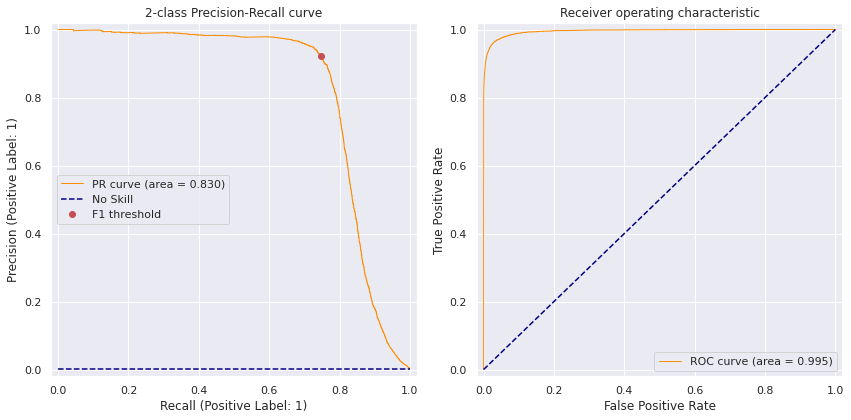

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

no_skill = y_test.sum().values[0].get()/len(y_test)
ax[0].plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % auprc)
ax[0].plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
ax[0].plot(recall[np.argmax((2 * precision * recall)/ (precision + recall))],
           precision[np.argmax((2 * precision * recall)/ (precision + recall))], 'ro', label='F1 threshold')
ax[0].set_xlabel('Recall (Positive Label: 1)')
ax[0].set_ylabel('Precision (Positive Label: 1)')
ax[0].set_title('2-class Precision-Recall curve')
ax[0].set_xlim([-0.02, 1.02])
ax[0].set_ylim([-0.02, 1.02])
ax[0].legend()

fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = roc_auc_score(true_labels, preds)

ax[1].plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_xlim([-0.02, 1.02])
ax[1].set_ylim([-0.02, 1.02])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend(loc="lower right")
plt.tight_layout()

Confusion Matrix :


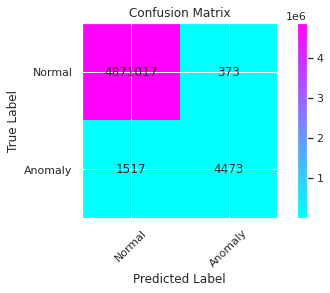

In [75]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.cool):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

In [76]:
len(thresholds)

3335520

In [77]:
# We can also use a custom threshold to balance out FP and FN, for example, to reduce FN (and increase FP):

threshold_idx = np.argmin(np.abs(recall-0.95))  # high recall, low precision.
print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
pred_labels = (preds > thresholds[threshold_idx]).astype(int)

print('fraud predicted', pred_labels.sum())
print('actual fraud', true_labels.sum())
# compute the auc, this should match the last test auc output above
auc_measure = roc_auc_score(true_labels, preds)
print(f'AUC {auc_measure: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {f1_score(true_labels, pred_labels): 0.4f}')


Precision:  0.0568
Recall:  0.9499
fraud predicted 100177
actual fraud 5990
AUC  0.9951
Accuracy:  0.9806
F1:  0.1072


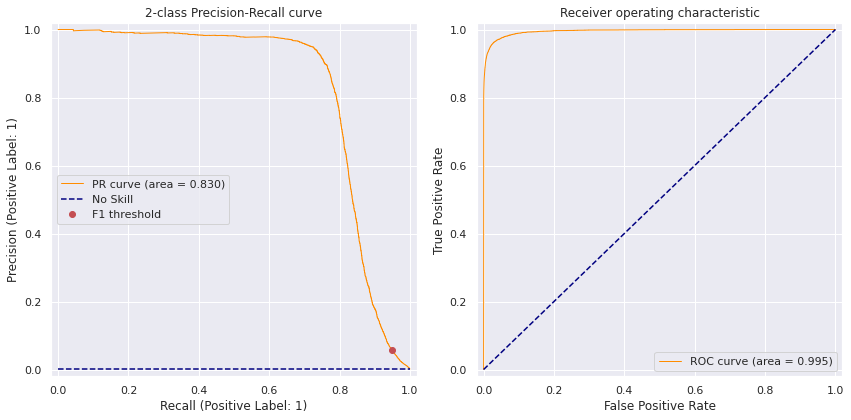

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

no_skill = y_test.sum().values[0].get()/len(y_test)
ax[0].plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % auprc)
ax[0].plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
ax[0].plot(recall[threshold_idx],
           precision[threshold_idx], 'ro', label='F1 threshold')
ax[0].set_xlabel('Recall (Positive Label: 1)')
ax[0].set_ylabel('Precision (Positive Label: 1)')
ax[0].set_title('2-class Precision-Recall curve')
ax[0].set_xlim([-0.02, 1.02])
ax[0].set_ylim([-0.02, 1.02])
ax[0].legend()

fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = roc_auc_score(true_labels, preds)

ax[1].plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_xlim([-0.02, 1.02])
ax[1].set_ylim([-0.02, 1.02])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend(loc="lower right")
plt.tight_layout()

Confusion Matrix :


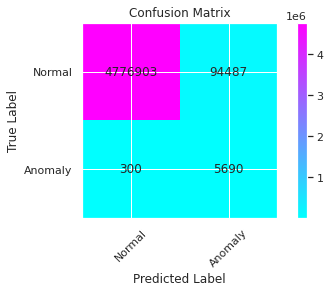

In [79]:
# and with the new threshold we see the reduced FN at cost of increased FP
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

plot_confusion_matrix(results, ['Normal','Anomaly'])

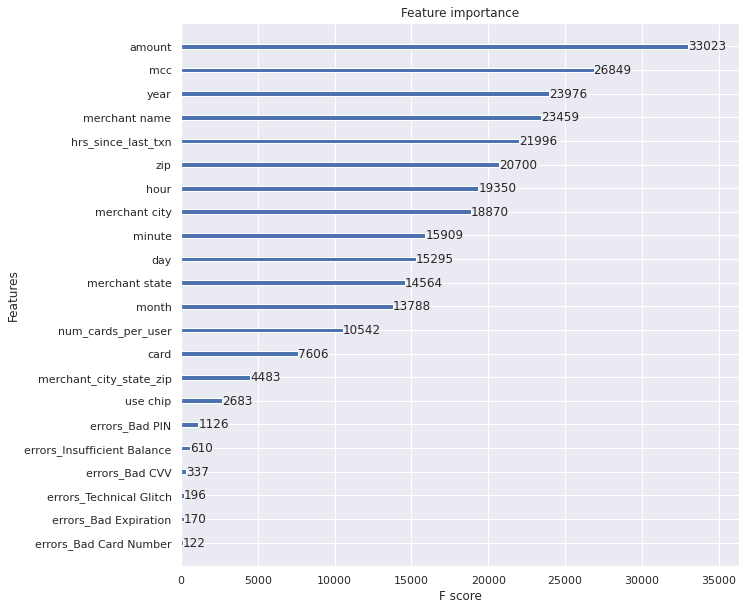

In [50]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

## Explainability with `Shap` 

In [51]:
import shap

explainer = shap.TreeExplainer(model)
%time shap_values = explainer.shap_values(X_test)

CPU times: user 6min 3s, sys: 3min 31s, total: 9min 34s
Wall time: 9min 34s


In [52]:
y_test.loc[8407470]

is_fraud    1
Name: 8407470, dtype: int8

In [53]:
X_test.loc[8407470]#.values

amount                           296.900000
hrs_since_last_txn                 0.816667
card                               0.000000
num_cards_per_user                 4.000000
year                              19.000000
month                              8.000000
day                               20.000000
hour                               4.000000
minute                            33.000000
use chip                           1.000000
merchant name                  74934.000000
merchant city                   8656.000000
merchant state                     0.000000
zip                                0.000000
mcc                              378.000000
merchant_city_state_zip        17915.000000
errors_Bad CVV                     0.000000
errors_Bad Card Number             0.000000
errors_Bad Expiration              0.000000
errors_Bad PIN                     0.000000
errors_Bad Zipcode                 0.000000
errors_Insufficient Balance        0.000000
errors_Technical Glitch         

In [54]:
fraud_example = X_test.loc[[8407470]]

In [55]:
print('\n'.join([f"use_chip \t {mappings['unq_use_chip'][fraud_example['use chip']][0]}",
          f"mcc\t{mappings['all_mccs'][fraud_example['mcc'].values.get()[0]]}",
          f"merchant city\t{mappings['merc_city_uniq'][fraud_example['merchant city']][0]}",
          f"zip\t{mappings['zip_uniq'][fraud_example['zip']][0]}"]))

use_chip 	 Online Transaction
mcc	3596
merchant city	ONLINE
zip	


In [56]:
iso18245.get_mcc('3596')

MCC(mcc='3596', range=MCCRange(start='3000', end='3999', description='Reserved for private use', reserved=True), iso_description='', usda_description='', stripe_description='', stripe_code='', visa_description='WYNN LAS VEGAS', visa_req_clearing_name='')

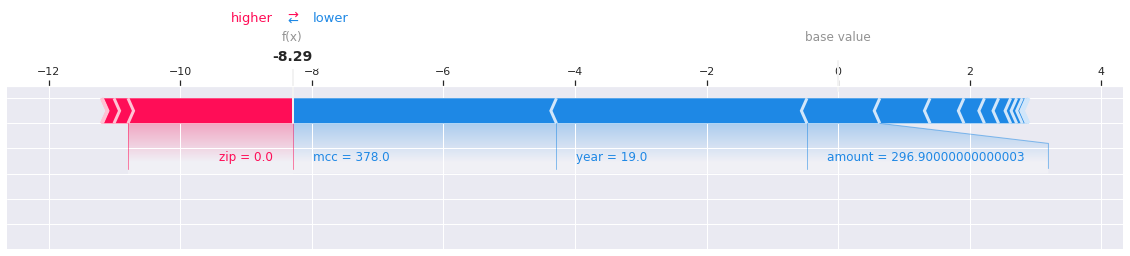

In [57]:
# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test.iloc[486].values.get(),
    feature_names=X_test.columns.tolist(),
    matplotlib=True
)

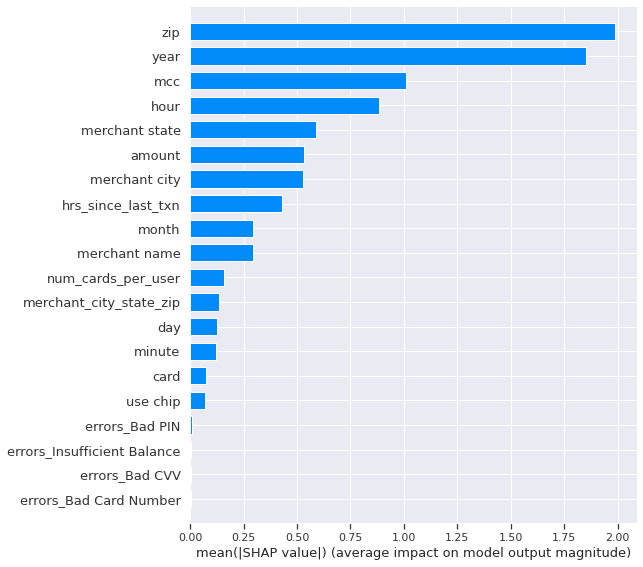

CPU times: user 588 ms, sys: 258 ms, total: 846 ms
Wall time: 845 ms


In [58]:
%time shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns.tolist())